In [8]:
# %% Imports
from sklearn.model_selection import train_test_split
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax
import pandas as pd
import numpy as np

# %% Load dataset and create train-test sets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Extract features and target
X_train = train_data.iloc[:, :-1].to_numpy()  # Features
y_train = train_data.iloc[:, -1].to_numpy()   # Target
X_test = test_data.iloc[:, :-1].to_numpy()    # Test features
y_test = test_data.iloc[:, -1].to_numpy()     # Test target

In [ ]:
# Define variable names
var_names = ["Feature_" + str(i) for i in range(X_train.shape[1])]

# Define the hyperparameter grid
param_grid = {
    'nr_clus': [2, 3, 4, 5, 7 ],  # Number of clusters
    'clustering_method': ['fcm', 'gk']  # Clustering methods
}

# Perform grid search
best_params = None
best_score = 0
best_metrics = {}

for nr_clus in param_grid['nr_clus']:
    for method in param_grid['clustering_method']:
        print(f"\nTesting parameters: nr_clus={nr_clus}, method={method}")

        # %% Cluster the input-output space
        cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=nr_clus)
        clust_centers, part_matrix, _ = cl.cluster(method=method)

        # Debugging: Check cluster centers and partition matrix
        print(f"Cluster Centers (Shape: {clust_centers.shape}):\n{clust_centers}")
        print(f"Partition Matrix (Shape: {part_matrix.shape}): First Row:\n{part_matrix[0]}")

        # %% Estimate membership functions parameters
        ae = AntecedentEstimator(X_train, part_matrix)
        antecedent_params = ae.determineMF()

        # Debugging: Print a summary of the membership functions
        print(f"Antecedent Parameters: {antecedent_params}")

        # %% Estimate consequent parameters
        ce = ConsequentEstimator(X_train, y_train, part_matrix)
        conseq_params = ce.suglms()

        # %% Build first-order Takagi-Sugeno model
        modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
        model = modbuilder.get_model()

        # %% Get model predictions
        modtester = SugenoFISTester(model, X_test, var_names)
        y_pred_probs = clip(modtester.predict()[0], 0, 1)
        y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
        y_pred = argmax(y_pred_probs, axis=1)

        # Debugging: Check predictions
        print(f"Predictions (Sample): {y_pred[:10]}")

        # %% Compute classification metrics
        acc_score = accuracy_score(y_test, y_pred)
        rec_score = recall_score(y_test, y_pred)
        prec_score = precision_score(y_test, y_pred)
        F1_score = f1_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)

        print(f"Results: Accuracy={acc_score:.3f}, Precision={prec_score:.3f}, Recall={rec_score:.3f}, "
              f"F1={F1_score:.3f}, Kappa={kappa:.3f}")

        # Update best parameters if this configuration is better
        if acc_score > best_score:
            best_score = acc_score
            best_params = {'nr_clus': nr_clus, 'method': method}
            best_metrics = {
                'accuracy': acc_score,
                'precision': prec_score,
                'recall': rec_score,
                'f1': F1_score,
                'kappa': kappa
            }

# Output the best parameters and their metrics
print("\nBest Hyperparameters and Metrics:")
print(f"Best Parameters: {best_params}")
print(f"Metrics: {best_metrics}")


Testing parameters: nr_clus=3, method=fcm
Cluster Centers (Shape: (3, 96)):
[[4.62797212e-01 5.09872375e-01 5.08757332e-01 6.03198050e-01
  6.03207366e-01 9.98757955e-01 7.96996566e-01 8.08905818e-01
  3.03279483e-01 7.81195922e-01 1.88675498e+09 1.71155303e+09
  4.63880485e-01 1.00554366e+07 7.61190908e-02 1.75898363e-01
  1.75828836e-01 1.75922266e-01 2.08953994e-01 3.19933226e-01
  5.70572480e+05 9.84744441e-02 1.66344246e-01 2.22677765e-02
  8.47482901e-01 6.87674050e-01 6.87701485e-01 2.17425978e-01
  5.18429972e+09 5.61779587e+06 2.63742050e-01 3.76608400e-01
  1.12510144e-02 1.37356898e+07 6.30770234e-01 5.81143845e+06
  1.48854304e-01 8.51145696e-01 8.82791902e-03 3.82756176e-01
  8.04908861e-03 9.84941002e-02 1.65512027e-01 4.05840895e-01
  1.23738631e-01 8.03714091e+06 5.51819259e+06 2.02551427e+09
  1.40976769e+09 4.05150562e-02 8.34782920e+06 3.92255011e-01
  9.14781231e+06 7.84596216e-01 3.56298660e-01 5.01805578e-01
  8.69470894e-02 2.32185241e+06 1.13609382e+08 1.174923

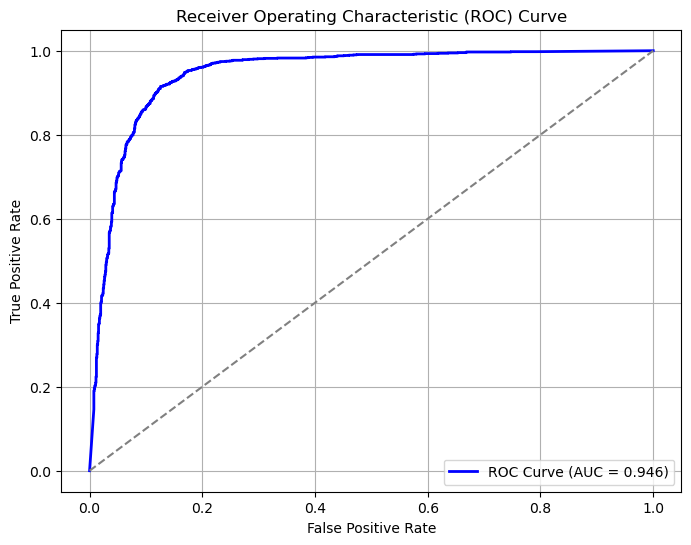

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 1])  # Use probabilities for the positive class
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
